<center>
<h2>Machine Learning for Times Series Project</h2>
<h3>Shape and Time Distortion Loss for Training Deep Time Series Forecasting Models</h3>
<hr>
<strong> Ben KABONGO B. </strong> & <strong> Martin Brosset </strong><br/>
M2 MVA, ENS Paris-Saclay<br/>
<hr>
</center>

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import warnings

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

sys.path.append("../src/")
from seq2seq import Seq2SeqModel
from dilate import DilateLoss

In [2]:
plt.style.use("bmh")
warnings.filterwarnings(action="ignore")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Functions

In [3]:
def train(model, train_dataloader, test_dataloader, lr, n_epochs=1_000, alpha=0.01, gamma=0.01, train_loss="MSE"):

    all_train_loss = []
    shape_train_loss = []
    temporal_train_loss = []

    mse_test_loss = []
    dilate_test_loss = []
    shape_test_loss = []
    temporal_test_loss = []

    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    mse_loss = torch.nn.MSELoss()
    dilate_loss = DilateLoss(alpha=alpha, gamma=gamma, device=device)

    tqdm_bar = tqdm(range(1, 1 + n_epochs), "Training")
    
    for epoch in tqdm_bar:
        model.train()
        epoch_train_loss = 0
        epoch_shape_train_loss = 0
        epoch_temporal_train_loss = 0

        for inputs, targets in train_dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            if train_loss == "MSE":
                loss = mse_loss(targets, outputs)
            else:
                loss, shape_loss, temporal_loss = dilate_loss(targets, outputs)
                epoch_shape_train_loss += shape_loss.item()
                epoch_temporal_train_loss += temporal_loss.item()

            epoch_train_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        all_train_loss.append(epoch_train_loss)
        if train_loss == "DILATE":
            shape_train_loss.append(epoch_shape_train_loss)
            temporal_train_loss.append(epoch_temporal_train_loss)

        model.eval()
        epoch_mse_test_loss = 0
        epoch_dilate_test_loss = 0
        epoch_shape_test_loss = 0
        epoch_temporal_test_loss = 0

        with torch.no_grad():
            for inputs, targets in test_dataloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)

                loss = mse_loss(targets, outputs)
                epoch_mse_test_loss += loss.item()

                loss, shape_loss, temporal_loss = dilate_loss(targets, outputs)
                epoch_dilate_test_loss += loss.item()
                epoch_shape_test_loss += shape_loss.item()
                epoch_temporal_test_loss += temporal_loss.item()

        mse_test_loss.append(epoch_mse_test_loss)
        dilate_test_loss.append(epoch_dilate_test_loss)
        shape_test_loss.append(epoch_shape_test_loss)
        temporal_test_loss.append(epoch_temporal_test_loss)

        description = f"[Epoch {epoch}/{n_epochs}] loss : train = {epoch_train_loss:.2f}"
        if train_loss == "DILATE":
            description += f" shape = {epoch_shape_train_loss:.2f} temp = {epoch_temporal_train_loss:.2f}"
        description += f" mse test = {epoch_mse_test_loss:.2f}"
        description += f" dilate test = {epoch_dilate_test_loss:.2f} shape = {epoch_shape_test_loss:.2f} temp = {epoch_temporal_test_loss:.2f}"
        tqdm_bar.set_description(description)

    return all_train_loss, mse_test_loss, dilate_test_loss, shape_train_loss, temporal_train_loss, shape_test_loss, temporal_test_loss

## ECG 50000

In [4]:
DATA_PATH = "../data/"

In [5]:
ecg_train = np.array(pd.read_table(DATA_PATH + "ECG5000/ECG5000_TRAIN.tsv"))[:, :, np.newaxis]
ecg_test = np.array(pd.read_table(DATA_PATH + "ECG5000/ECG5000_TEST.tsv"))[:, :, np.newaxis]

In [6]:
ecg_train.shape, ecg_test.shape

((499, 141, 1), (4499, 141, 1))

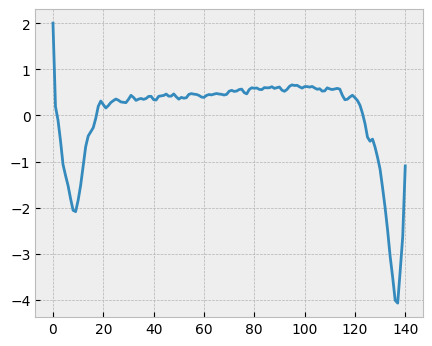

In [7]:
plt.figure(figsize=(5, 4))
plt.plot(ecg_train[333])
plt.show()

In [8]:
class ECG5000Dataset(Dataset):

    def __init__(self, data, output_length=56):
        self.data = torch.from_numpy(data).to(dtype=torch.float32)
        self.output_length = output_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index, :-self.output_length], self.data[index, -self.output_length:]

In [9]:
batch_size = 32
ecg_train_dataset = ECG5000Dataset(ecg_train)
ecg_test_dataset = ECG5000Dataset(ecg_test)
ecg_train_dataloader = DataLoader(ecg_train_dataset, batch_size=batch_size, shuffle=True)
ecg_test_dataloader = DataLoader(ecg_test_dataset, batch_size=batch_size, shuffle=False)

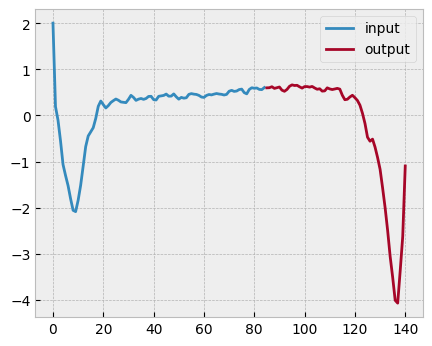

In [10]:
input, output = ecg_train_dataset[333]
input, output = input.numpy(), output.numpy()
plt.figure(figsize=(5, 4))
plt.plot(np.arange(0, len(input)), input, label="input")
plt.plot(np.arange(len(input), len(input) + len(output)), output, label="output")
plt.legend()
plt.show()

### Train loss = MSE

In [11]:
lr = 1e-3
n_epochs = 200
model = Seq2SeqModel(output_length=56, input_size=1, hidden_size=128, projection_size=16, num_layers=1, device=device)
all_train_loss, mse_test_loss, dilate_test_loss, shape_train_loss, temporal_train_loss, shape_test_loss, temporal_test_loss = train(
    model, ecg_train_dataloader, ecg_test_dataloader, lr, n_epochs, train_loss="MSE"
)

[Epoch 9/200] loss : train = 12.99 mse test = 111.51 dilate test = 393.58 shape = 3873.37 temp = 358.43:   4%|▍         | 9/200 [26:38<9:24:42, 177.39s/it]  

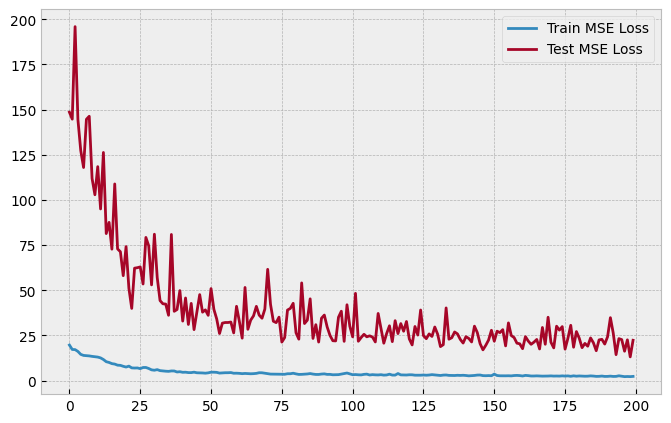

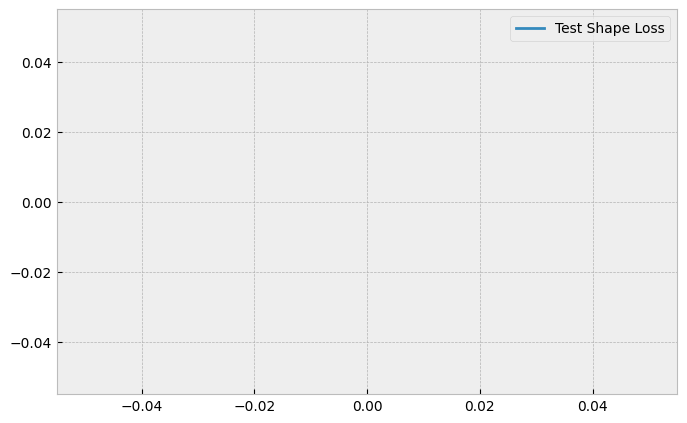

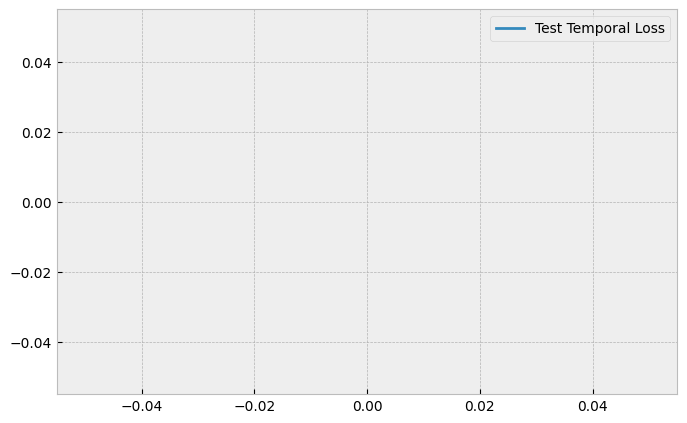

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(all_train_loss, label="Train MSE")
plt.plot(mse_test_loss, label="Test MSE")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(dilate_test_loss, label="Test DILATE")
plt.plot(mse_test_loss, label="Test MSE")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(shape_test_loss, label="Test Shape")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(temporal_test_loss, label="Test Temporal")
plt.legend()
plt.show()

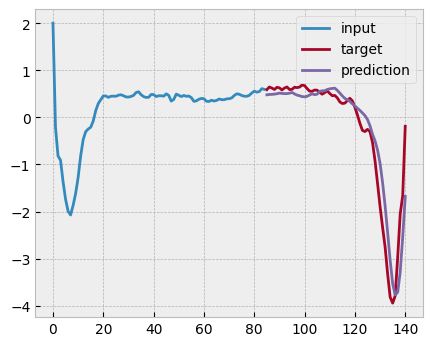

In [ ]:
model.eval()
input, target = ecg_test_dataset[3333]
prediction  = model(input.unsqueeze(0)).squeeze()
input, target, prediction = input.numpy(), target.numpy(), prediction.detach().numpy()
plt.figure(figsize=(5, 4))
plt.plot(np.arange(0, len(input)), input, label="input")
plt.plot(np.arange(len(input), len(input) + len(target)), target, label="target")
plt.plot(np.arange(len(input), len(input) + len(target)), prediction, label="prediction")
plt.legend()
plt.show()

### Train loss = DILATE

In [ ]:
lr = 1e-3
n_epochs = 200
model = Seq2SeqModel(output_length=56, input_size=1, hidden_size=128, projection_size=16, num_layers=1, device=device)
all_train_loss, all_test_loss, shape_train_loss, temporal_train_loss, shape_test_loss, temporal_test_loss = train(
    model, ecg_train_dataloader, ecg_test_dataloader, lr, n_epochs, alpha=0.5, gamma=0.01
    train_loss="DILATE", 
)